In [1]:
!pip install ntscraper

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from ntscraper import Nitter
import pandas as pd
import numpy as np
import torch

# Initialize the scraper and the model
scraper = Nitter(log_level=1, skip_instance_check=False)
tweets = scraper.get_tweets('elonmusk', mode='user', number=100)
roberta = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)
labels = ['Negative', 'Neutral', 'Positive']

sentiments = []

# Process tweets and collect scores
if 'tweets' in tweets and tweets['tweets']:
    for tweet_info in tweets['tweets']:
        tweet_words = [('@user' if word.startswith('@') and len(word) > 1 else 'http' if word.startswith('http') else word) for word in tweet_info['text'].split()]
        tweet_proc = " ".join(tweet_words)

        # Tokenize the tweet
        inputs = tokenizer(tweet_proc, return_tensors='pt', max_length=512, truncation=True, padding=True)

        # Make sure token_type_ids is not None
        if 'token_type_ids' not in inputs:
            inputs['token_type_ids'] = torch.tensor([[0] * len(inputs['input_ids'])])  # Assuming single segment

        output = model(**inputs)
        scores = softmax(output.logits.detach().numpy())
        sentiments.append(scores.tolist()[0])  # Append only the first element of the list

    # Convert sentiments to a DataFrame
    df_sentiments = pd.DataFrame(sentiments, columns=labels)
else:
    print("No tweets found or error in fetching tweets.")


Testing instances: 100%|██████████| 77/77 [01:31<00:00,  1.19s/it]
INFO:root:No instance specified, using random instance https://nitter.privacydev.net
INFO:root:Current stats for elonmusk: 20 tweets, 0 threads...
INFO:root:Current stats for elonmusk: 40 tweets, 0 threads...
INFO:root:Current stats for elonmusk: 60 tweets, 0 threads...
INFO:root:Current stats for elonmusk: 80 tweets, 0 threads...
INFO:root:Current stats for elonmusk: 100 tweets, 0 threads...


<ipython-input-7-bfa950ae81ad>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=average_scores.index, y=average_scores.values, palette='coolwarm')


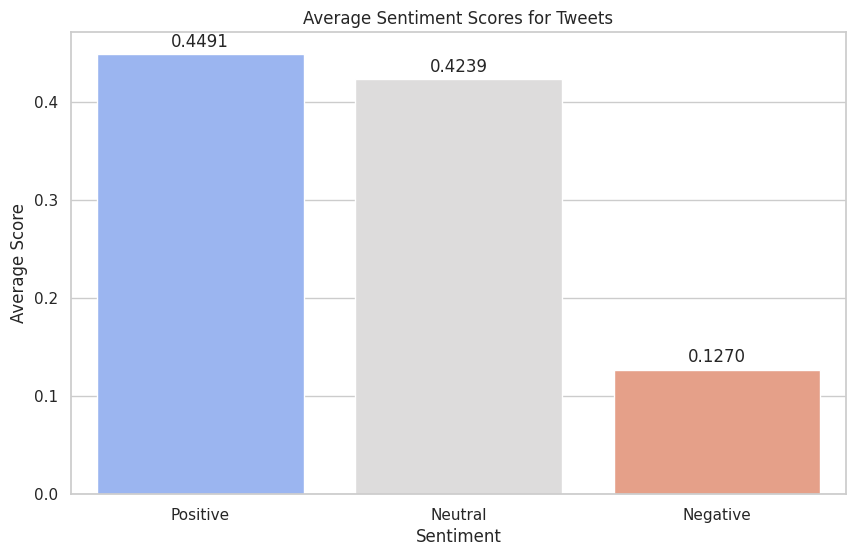

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Calculate the average sentiment scores
average_scores = df_sentiments.mean().sort_values(ascending=False)

# Create a bar plot for the average sentiment scores
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=average_scores.index, y=average_scores.values, palette='coolwarm')
plt.title('Average Sentiment Scores for Tweets')
plt.ylabel('Average Score')
plt.xlabel('Sentiment')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.show()